In [5]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt

In [6]:
img_rows, img_cols = 32 , 32

In [7]:
isolated_train_path = r'H:\CVPR\bng_isolated_num\Train'
isolated_test_path = r'H:\CVPR\bng_isolated_num\Test'

In [8]:
for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        Grey = img.resize((img_rows, img_cols))
        #img = ImageOps.invert(img)
        #Grey = img.convert('L')
        #ret,thresh1 = cv.threshold(Grey,127,255,cv.THRESH_BINARY)
        #threshold = 105
        #Grey = Grey.point(lambda p: p < threshold and 255)
        #Grey = ImageOps.invert(img)
        Grey = Grey.convert('RGB')
        Grey.save(file_path)

In [9]:
train_data_dir = isolated_train_path
validation_data_dir = isolated_test_path

In [10]:
img_width, img_height, channel = img_rows, img_cols, 3
batch_size = 32

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= True,
        class_mode ='categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= False,
        class_mode ='categorical')

Found 15794 images belonging to 10 classes.
Found 3946 images belonging to 10 classes.


In [12]:
IMG_SHAPE = img_cols, img_rows, 3
classes = 10

In [13]:
num_epoch = 50
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 15794
num_validation_samples: 3946


In [14]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

In [15]:
def batch_normalization_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
   
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    
    return x

In [16]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = batch_normalization_relu_conv(tensor, filters=4*k, kernel_size=1)
        x = batch_normalization_relu_conv(x, filters=k, kernel_size=3)
        #x =  tensorflow.keras.layers.Dropout(0.1)(x)
        tensor = Concatenate()([tensor, x])
    return tensor

In [17]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = batch_normalization_relu_conv(x, filters=f, kernel_size=1)
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    #x = BatchNormalization()(x)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

In [18]:
k = 12
theta = 0.5
repetitions = 10, 14, 16
input_layer = Input(IMG_SHAPE)

In [19]:
x = Conv2D(2*k, 7, strides=2, padding='same')(input_layer)
x = Dropout(0.1)(x)
x = MaxPool2D(3, strides=2, padding='same')(x)
#x = BatchNormalization()(x)

In [20]:
d = None
for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)
    #x = BatchNormalization()(x)
    
#x = BatchNormalization()(x)
x = GlobalAvgPool2D()(d)

output_layer = Dense(classes, activation='softmax')(x)

model = Model(input_layer, output_layer)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 24)   3552        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 16, 16, 24)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 24)     0           ['dropout[0][0]']                
                                                                                              

In [22]:
opt = tensorflow.keras.optimizers.Adam()

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [24]:
history_1= model.fit_generator(train_generator,
                    steps_per_epoch=num_train_samples // batch_size,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=num_validation_samples // batch_size)

C:\Users\va5to\AppData\Local\Temp\ipykernel_22512\193625105.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1= model.fit_generator(train_generator,


Epoch 1/50
493/493 [==============================] - 114s 186ms/step - loss: 0.3718 - accuracy: 0.8847 - val_loss: 0.1857 - val_accuracy: 0.9444
Epoch 2/50
493/493 [==============================] - 53s 107ms/step - loss: 0.1344 - accuracy: 0.9605 - val_loss: 0.1950 - val_accuracy: 0.9436
Epoch 3/50
493/493 [==============================] - 51s 103ms/step - loss: 0.1005 - accuracy: 0.9697 - val_loss: 0.1416 - val_accuracy: 0.9611
Epoch 4/50
493/493 [==============================] - 50s 102ms/step - loss: 0.0747 - accuracy: 0.9775 - val_loss: 0.1355 - val_accuracy: 0.9591
Epoch 5/50
493/493 [==============================] - 50s 102ms/step - loss: 0.0675 - accuracy: 0.9787 - val_loss: 0.1439 - val_accuracy: 0.9563
Epoch 6/50
493/493 [==============================] - 50s 101ms/step - loss: 0.0589 - accuracy: 0.9820 - val_loss: 0.1116 - val_accuracy: 0.9682
Epoch 7/50
493/493 [==============================] - 49s 99ms/step - loss: 0.0521 - accuracy: 0.9843 - val_loss: 0.0991 - val_ac

In [25]:
import seaborn as sns

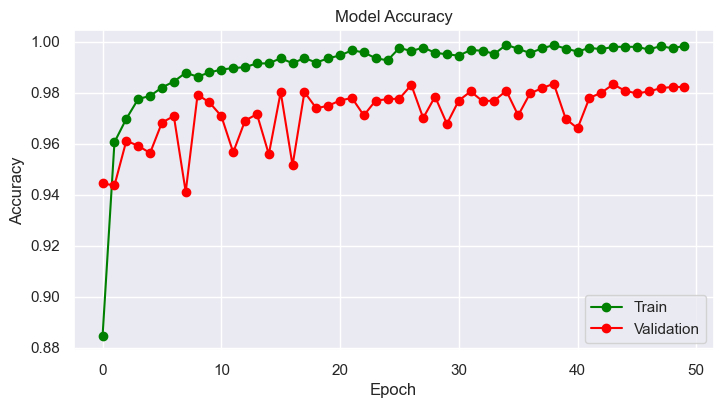

In [26]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['accuracy'], 'o-', color="Green")
plt.plot(history_1.history['val_accuracy'] , 'o-', color="Red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig(r'H:\CVPR\Graph\NumberDenseAccuracy1.svg')
plt.savefig(r'H:\CVPR\Graph\NumberDenseAccuracy1.png')

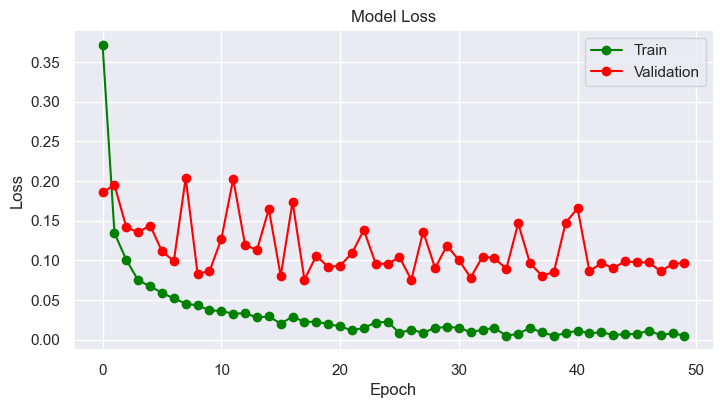

In [27]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['loss'], 'o-', color="Green")
plt.plot(history_1.history['val_loss'], 'o-', color="Red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig(r'H:\CVPR\Graph\NumberDenseLoss1.svg')
plt.savefig(r'H:\CVPR\Graph\NumberDenseLoss1.png')

In [28]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
batch_size=32

In [30]:
Y_pred = model.predict_generator(validation_generator, num_validation_samples// batch_size+1)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['51', '52', '53', '54', '55', '56', '57', '58', '59', '60']
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

C:\Users\va5to\AppData\Local\Temp\ipykernel_22512\1013000355.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_validation_samples// batch_size+1)


(3946, 10)
              precision    recall  f1-score   support

          51      0.968     0.985     0.976       396
          52      0.982     0.965     0.973       396
          53      0.992     0.990     0.991       390
          54      0.968     0.985     0.976       395
          55      0.975     0.990     0.982       396
          56      0.982     0.980     0.981       397
          57      0.995     0.962     0.978       396
          58      0.995     0.985     0.990       391
          59      0.995     0.992     0.994       396
          60      0.973     0.990     0.981       393

    accuracy                          0.982      3946
   macro avg      0.982     0.982     0.982      3946
weighted avg      0.982     0.982     0.982      3946



In [31]:
cm = confusion_matrix(y_true, y_pred)

In [32]:
classes=10

In [33]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.BuGn
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

In [34]:
import imp
imp.reload(sns)

C:\Users\va5to\AppData\Local\Temp\ipykernel_22512\31953510.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'seaborn' from 'C:\\Users\\va5to\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

In [35]:
sns.reset_defaults()

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# plt.figure() 
# prop = FontProperties()
# prop.set_file('Siyamrupali.ttf')

In [37]:
cm_plot_labels = ['61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81','82','83','84']
#sns.set_theme()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig(r'H:\CVPR\Graph\SimpleDenseCNF1.svg')
plt.savefig(r'H:\CVPR\Graph\SimpleDenseCNF1.png')

Confusion matrix, without normalization
[[390   4   0   0   0   1   0   0   0   1]
 [  3 382   0   1   0   0   0   2   0   8]
 [  1   3 386   0   0   0   0   0   0   0]
 [  4   0   0 389   1   1   0   0   0   0]
 [  1   0   0   1 392   1   0   0   0   1]
 [  3   0   0   0   2 389   2   0   1   0]
 [  0   0   0   9   1   4 381   0   1   0]
 [  0   0   2   0   3   0   0 385   0   1]
 [  1   0   0   1   1   0   0   0 393   0]
 [  0   0   1   1   2   0   0   0   0 389]]
